In [70]:
import pandas as pd
import torch
from fastai.tabular.all import *

In [71]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100000)

# Зареждане на данните

In [72]:
dataset = pd.read_csv('../data/prepared-car-offers.csv')

In [73]:
dataset.sample(20)

,Make,Model,BodyType,FuelType,Transmission,EngineSize,Horsepower,EuroStandard,Mileage,MilesPerFullCharge (EV),BatteryCapacity (EV),Color,Price,Region,SafetyFeatures_GPS система за проследяване,SafetyFeatures_Автоматичен контрол на стабилността,SafetyFeatures_Адаптивни предни светлини,SafetyFeatures_Антиблокираща система,SafetyFeatures_Въздушни възглавници - Задни,SafetyFeatures_Въздушни възглавници - Предни,SafetyFeatures_Въздушни възглавници - Странични,SafetyFeatures_Ел. разпределяне на спирачното усилие,SafetyFeatures_Електронна програма за стабилизиране,SafetyFeatures_Контрол на налягането на гумите,SafetyFeatures_Парктроник,SafetyFeatures_Система ISOFIX,SafetyFeatures_Система за динамична устойчивост,SafetyFeatures_Система за защита от пробуксуване,SafetyFeatures_Система за изсушаване на накладките,SafetyFeatures_Система за контрол на дистанцията,SafetyFeatures_Система за контрол на спускането,SafetyFeatures_Система за подпомагане на спирането,ComfortFeatures_Auto Start Stop function,ComfortFeatures_Bluetooth \ handsfree система,ComfortFeatures_DVD,ComfortFeatures_IN\AUX изводи,ComfortFeatures_Steptronic,ComfortFeatures_TV,ComfortFeatures_Tiptronic,ComfortFeatures_USB,ComfortFeatures_audio\video,ComfortFeatures_Адаптивно въздушно окачване,ComfortFeatures_Безключово палене,ComfortFeatures_Блокаж на диференциала,ComfortFeatures_Бордкомпютър,ComfortFeatures_Бързи \ бавни скорости,ComfortFeatures_Датчик за светлина,ComfortFeatures_Ел. Огледала,ComfortFeatures_Ел. Стъкла,ComfortFeatures_Ел. регулиране на окачването,ComfortFeatures_Ел. регулиране на седалките,ComfortFeatures_Ел. усилвател на волана,ComfortFeatures_Климатик,ComfortFeatures_Климатроник,ComfortFeatures_Мултифункционален волан,ComfortFeatures_Навигация,ComfortFeatures_Отопление на волана,ComfortFeatures_Печка,ComfortFeatures_Подгряване на предното стъкло,ComfortFeatures_Подгряване на седалките,ComfortFeatures_Регулиране на волана,ComfortFeatures_Сензор за дъжд,ComfortFeatures_Серво усилвател на волана,ComfortFeatures_Система за измиване на фаровете,ComfortFeatures_Система за контрол на скоростта (автопилот),ComfortFeatures_Стерео уредба,ComfortFeatures_Термопомпа,ComfortFeatures_Хладилна жабка,OtherFeatures_4x4,OtherFeatures_7 места,OtherFeatures_Buy back,OtherFeatures_Бартер,OtherFeatures_Газова уредба,OtherFeatures_Дълга база,OtherFeatures_Капариран\Продаден,OtherFeatures_Катастрофирал,OtherFeatures_Къса база,OtherFeatures_Лизинг,OtherFeatures_Метанова уредба,OtherFeatures_На части,OtherFeatures_Напълно обслужен,OtherFeatures_Нов внос,OtherFeatures_С регистрация,OtherFeatures_Сервизна книжка,OtherFeatures_Тунинг,ExteriorFeatures_2(3) Врати,ExteriorFeatures_4(5) Врати,ExteriorFeatures_LED фарове,ExteriorFeatures_Ксенонови фарове,ExteriorFeatures_Лети джанти,ExteriorFeatures_Металик,ExteriorFeatures_Панорамен люк,ExteriorFeatures_Рейлинг на покрива,ExteriorFeatures_Спойлери,ExteriorFeatures_Теглич,ExteriorFeatures_Халогенни фарове,ExteriorFeatures_Шибедах,SecurityFeatures_OFFROAD пакет,SecurityFeatures_Аларма,SecurityFeatures_Брониран,SecurityFeatures_Каско,SecurityFeatures_Лебедка,SecurityFeatures_Централно заключване,InteriorFeatures_Велурен салон,InteriorFeatures_Десен волан,InteriorFeatures_Кожен салон,SpecialisedFeatures_TAXI,SpecialisedFeatures_За хора с увреждания,SpecialisedFeatures_Катафалка,SpecialisedFeatures_Линейка,SpecialisedFeatures_Учебен,SpecialisedFeatures_Хладилен,SpecialisedFeatures_Хомологация N1,Age,TotalSafetyFeatures,TotalComfortFeatures,TotalOtherFeatures,TotalExteriorFeatures,TotalSecurityFeatures,TotalInteriorFeatures,TotalSpecialisedFeatures
12663,BMW,5-серия,Седан,Дизелов,Автоматична,3000.00,231.00,Евро 4,290000.00,NaN,NaN,Сив,15600.00,Враца,0,1,1,1,1,1,1,0,1,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,16,12,18,3,5,1,1,0
51132,Nissan,Navara,Пикап,Дизелов,Ръчна,NaN,133.00,NaN,279000.00,NaN,NaN,Зелен,1280

In [74]:
dataset = dataset.drop(columns='Region')

In [75]:
model_categories = dataset['Model'].unique()
dataset_no_model_outliers = dataset.copy()

for model in model_categories:
    iqr = dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.75) - dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.25)
    lower_bound = dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.25) - 1.5 * iqr
    upper_bound = dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.75) + 1.5 * iqr
    dataset_no_model_outliers = dataset_no_model_outliers[
        (dataset_no_model_outliers['Model'] != model) | 
        ((dataset_no_model_outliers['Model'] == model) & (dataset_no_model_outliers['Price'] >= lower_bound) & (dataset_no_model_outliers['Price'] <= upper_bound))
    ]
    
make_categories = dataset['Make'].unique()
dataset_no_make_model_outliers = dataset_no_model_outliers.copy()

for make in make_categories:
    iqr = dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.75) - dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.25)
    lower_bound = dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.25) - 1.5 * iqr
    upper_bound = dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.75) + 1.5 * iqr
    dataset_no_make_model_outliers = dataset_no_make_model_outliers[
        (dataset_no_make_model_outliers['Make'] != make) | 
        ((dataset_no_make_model_outliers['Make'] == make) & (dataset_no_make_model_outliers['Price'] >= lower_bound) & (dataset_no_make_model_outliers['Price'] <= upper_bound))
    ]
    
dataset_no_make_model_outliers.shape

(72787, 120)

In [76]:
dataset = dataset_no_make_model_outliers

# Попълване на липсващи числови стойности

In [77]:
dataset[dataset.select_dtypes(include=[np.float64]).columns] = dataset[dataset.select_dtypes(include=[np.float64]).columns].fillna(0)
dataset[dataset.select_dtypes(include=np.float64).columns] = dataset.select_dtypes(include=np.float64).astype(int)

# Конфигуриране на модела

In [78]:
splits = RandomSplitter(valid_pct=0.2)(range_of(dataset))

In [120]:
splits

((#58230) [np.int64(64065),np.int64(42796),np.int64(1713),np.int64(59335),np.int64(29578),np.int64(64815),np.int64(46412),np.int64(62109),np.int64(63000),np.int64(8130)...],
 (#14557) [np.int64(53056),np.int64(4018),np.int64(9597),np.int64(50558),np.int64(47411),np.int64(70198),np.int64(61501),np.int64(13760),np.int64(49707),np.int64(10164)...])

In [79]:
y_names = ['Price']
cat_names = dataset.select_dtypes(include=object).columns.to_list()
cont_names = dataset.drop(columns='Price').select_dtypes(include=np.number).columns.to_list()

cat_names, cont_names

(['Make',
  'Model',
  'BodyType',
  'FuelType',
  'Transmission',
  'EuroStandard',
  'Color'],
 ['EngineSize',
  'Horsepower',
  'Mileage',
  'MilesPerFullCharge (EV)',
  'BatteryCapacity (EV)',
  'SafetyFeatures_GPS система за проследяване',
  'SafetyFeatures_Автоматичен контрол на стабилността',
  'SafetyFeatures_Адаптивни предни светлини',
  'SafetyFeatures_Антиблокираща система',
  'SafetyFeatures_Въздушни възглавници - Задни',
  'SafetyFeatures_Въздушни възглавници - Предни',
  'SafetyFeatures_Въздушни възглавници - Странични',
  'SafetyFeatures_Ел. разпределяне на спирачното усилие',
  'SafetyFeatures_Електронна програма за стабилизиране',
  'SafetyFeatures_Контрол на налягането на гумите',
  'SafetyFeatures_Парктроник',
  'SafetyFeatures_Система ISOFIX',
  'SafetyFeatures_Система за динамична устойчивост',
  'SafetyFeatures_Система за защита от пробуксуване',
  'SafetyFeatures_Система за изсушаване на накладките',
  'SafetyFeatures_Система за контрол на дистанцията',
  'Safety

In [80]:
to = TabularPandas(dataset, procs=[Categorify, FillMissing, Normalize], cat_names=cat_names, cont_names=cont_names, y_names=y_names, splits=splits)
dls = to.dataloaders(bs=1000, device=torch.device('mps'))

In [81]:
dls.show_batch()

,Make,Model,BodyType,FuelType,Transmission,EuroStandard,Color,EngineSize,Horsepower,Mileage,MilesPerFullCharge (EV),BatteryCapacity (EV),SafetyFeatures_GPS система за проследяване,SafetyFeatures_Автоматичен контрол на стабилността,SafetyFeatures_Адаптивни предни светлини,SafetyFeatures_Антиблокираща система,SafetyFeatures_Въздушни възглавници - Задни,SafetyFeatures_Въздушни възглавници - Предни,SafetyFeatures_Въздушни възглавници - Странични,SafetyFeatures_Ел. разпределяне на спирачното усилие,SafetyFeatures_Електронна програма за стабилизиране,SafetyFeatures_Контрол на налягането на гумите,SafetyFeatures_Парктроник,SafetyFeatures_Система ISOFIX,SafetyFeatures_Система за динамична устойчивост,SafetyFeatures_Система за защита от пробуксуване,SafetyFeatures_Система за изсушаване на накладките,SafetyFeatures_Система за контрол на дистанцията,SafetyFeatures_Система за контрол на спускането,SafetyFeatures_Система за подпомагане на спирането,ComfortFeatures_Auto Start Stop function,ComfortFeatures_Bluetooth \ handsfree система,ComfortFeatures_DVD,ComfortFeatures_IN\AUX изводи,ComfortFeatures_Steptronic,ComfortFeatures_TV,ComfortFeatures_Tiptronic,ComfortFeatures_USB,ComfortFeatures_audio\video,ComfortFeatures_Адаптивно въздушно окачване,ComfortFeatures_Безключово палене,ComfortFeatures_Блокаж на диференциала,ComfortFeatures_Бордкомпютър,ComfortFeatures_Бързи \ бавни скорости,ComfortFeatures_Датчик за светлина,ComfortFeatures_Ел. Огледала,ComfortFeatures_Ел. Стъкла,ComfortFeatures_Ел. регулиране на окачването,ComfortFeatures_Ел. регулиране на седалките,ComfortFeatures_Ел. усилвател на волана,ComfortFeatures_Климатик,ComfortFeatures_Климатроник,ComfortFeatures_Мултифункционален волан,ComfortFeatures_Навигация,ComfortFeatures_Отопление на волана,ComfortFeatures_Печка,ComfortFeatures_Подгряване на предното стъкло,ComfortFeatures_Подгряване на седалките,ComfortFeatures_Регулиране на волана,ComfortFeatures_Сензор за дъжд,ComfortFeatures_Серво усилвател на волана,ComfortFeatures_Система за измиване на фаровете,ComfortFeatures_Система за контрол на скоростта (автопилот),ComfortFeatures_Стерео уредба,ComfortFeatures_Термопомпа,ComfortFeatures_Хладилна жабка,OtherFeatures_4x4,OtherFeatures_7 места,OtherFeatures_Buy back,OtherFeatures_Бартер,OtherFeatures_Газова уредба,OtherFeatures_Дълга база,OtherFeatures_Капариран\Продаден,OtherFeatures_Катастрофирал,OtherFeatures_Къса база,OtherFeatures_Лизинг,OtherFeatures_Метанова уредба,OtherFeatures_На части,OtherFeatures_Напълно обслужен,OtherFeatures_Нов внос,OtherFeatures_С регистрация,OtherFeatures_Сервизна книжка,OtherFeatures_Тунинг,ExteriorFeatures_2(3) Врати,ExteriorFeatures_4(5) Врати,ExteriorFeatures_LED фарове,ExteriorFeatures_Ксенонови фарове,ExteriorFeatures_Лети джанти,ExteriorFeatures_Металик,ExteriorFeatures_Панорамен люк,ExteriorFeatures_Рейлинг на покрива,ExteriorFeatures_Спойлери,ExteriorFeatures_Теглич,ExteriorFeatures_Халогенни фарове,ExteriorFeatures_Шибедах,SecurityFeatures_OFFROAD пакет,SecurityFeatures_Аларма,SecurityFeatures_Брониран,SecurityFeatures_Каско,SecurityFeatures_Лебедка,SecurityFeatures_Централно заключване,InteriorFeatures_Велурен салон,InteriorFeatures_Десен волан,InteriorFeatures_Кожен салон,SpecialisedFeatures_TAXI,SpecialisedFeatures_За хора с увреждания,SpecialisedFeatures_Катафалка,SpecialisedFeatures_Линейка,SpecialisedFeatures_Учебен,SpecialisedFeatures_Хладилен,SpecialisedFeatures_Хомологация N1,Age,TotalSafetyFeatures,TotalComfortFeatures,TotalOtherFeatures,TotalExteriorFeatures,TotalSecurityFeatures,TotalInteriorFeatures,TotalSpecialisedFeatures,Price
0,BMW,X3,Джип,Дизелов,Автоматична,Евро 5,Бял,3000.00,258.00,245000.00,-0.00,-0.00,-0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,-0.00,1.00,1.00,1.00,-0.00,1.00,1.00,1.00,-0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.0

In [82]:
learner = tabular_learner(dls, metrics=[rmse, mae], layers=[3000, 1000, 500, 250])

/Users/A1CD81D/python-venv/diploma/lib/python3.12/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=dev

SuggestedLRs(minimum=0.33113112449646, steep=1.5848931980144698e-06, valley=0.7585775852203369, slide=6.309573450380412e-07)

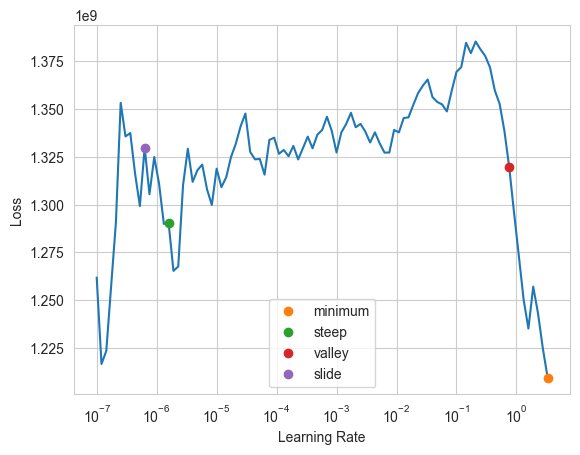

In [83]:
learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))

# Обучаване на модела

In [84]:
learner.fit(200, lr=0.002, cbs=[SaveModelCallback(fname='best-model', monitor='valid_loss')])

epoch,train_loss,valid_loss,_rmse,mae,time
0,1338152960.000000,1213777024.000000,34839.300781,21967.128906,00:00
1,1367311872.000000,1211332352.000000,34804.199219,21949.636719,00:00
2,1361563264.000000,1206881792.000000,34740.199219,21942.097656,00:00
3,1348965120.000000,1201167488.000000,34657.863281,21916.695312,00:00
4,1276344192.000000,1199042176.000000,34627.187500,21909.099609,00:00
5,1308605824.000000,1191768448.000000,34521.996094,21834.593750,00:00
6,1310219264.000000,1184010752.000000,34409.453125,21779.093750,00:00
7,1265598592.000000,1178792832.000000,34333.550781,21771.369141,00:00
8,1266829184.000000,1169617152.000000,34199.664062,21682.878906,00:00
9,1308222464.000000,1157083648.000000,34015.933594,21518.019531,00:00


Better model found at epoch 0 with valid_loss value: 1213777024.0.
Better model found at epoch 1 with valid_loss value: 1211332352.0.
Better model found at epoch 2 with valid_loss value: 1206881792.0.
Better model found at epoch 3 with valid_loss value: 1201167488.0.
Better model found at epoch 4 with valid_loss value: 1199042176.0.
Better model found at epoch 5 with valid_loss value: 1191768448.0.
Better model found at epoch 6 with valid_loss value: 1184010752.0.
Better model found at epoch 7 with valid_loss value: 1178792832.0.
Better model found at epoch 8 with valid_loss value: 1169617152.0.
Better model found at epoch 9 with valid_loss value: 1157083648.0.
Better model found at epoch 10 with valid_loss value: 1147528320.0.
Better model found at epoch 11 with valid_loss value: 1130096512.0.
Better model found at epoch 12 with valid_loss value: 1121455360.0.
Better model found at epoch 13 with valid_loss value: 1117096576.0.
Better model found at epoch 14 with valid_loss value: 1104

/Users/A1CD81D/python-venv/diploma/lib/python3.12/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=dev

In [85]:
learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop

# Анализ на резултатите

In [138]:
preds = learner.get_preds(dl=learner.dls.test_dl(dataset))
data_with_preds = dataset.copy()
data_with_preds['Predicted Price'] = preds[0].numpy()

In [139]:
data_with_preds.sample(20)

,Make,Model,BodyType,FuelType,Transmission,EngineSize,Horsepower,EuroStandard,Mileage,MilesPerFullCharge (EV),BatteryCapacity (EV),Color,Price,SafetyFeatures_GPS система за проследяване,SafetyFeatures_Автоматичен контрол на стабилността,SafetyFeatures_Адаптивни предни светлини,SafetyFeatures_Антиблокираща система,SafetyFeatures_Въздушни възглавници - Задни,SafetyFeatures_Въздушни възглавници - Предни,SafetyFeatures_Въздушни възглавници - Странични,SafetyFeatures_Ел. разпределяне на спирачното усилие,SafetyFeatures_Електронна програма за стабилизиране,SafetyFeatures_Контрол на налягането на гумите,SafetyFeatures_Парктроник,SafetyFeatures_Система ISOFIX,SafetyFeatures_Система за динамична устойчивост,SafetyFeatures_Система за защита от пробуксуване,SafetyFeatures_Система за изсушаване на накладките,SafetyFeatures_Система за контрол на дистанцията,SafetyFeatures_Система за контрол на спускането,SafetyFeatures_Система за подпомагане на спирането,ComfortFeatures_Auto Start Stop function,ComfortFeatures_Bluetooth \ handsfree система,ComfortFeatures_DVD,ComfortFeatures_IN\AUX изводи,ComfortFeatures_Steptronic,ComfortFeatures_TV,ComfortFeatures_Tiptronic,ComfortFeatures_USB,ComfortFeatures_audio\video,ComfortFeatures_Адаптивно въздушно окачване,ComfortFeatures_Безключово палене,ComfortFeatures_Блокаж на диференциала,ComfortFeatures_Бордкомпютър,ComfortFeatures_Бързи \ бавни скорости,ComfortFeatures_Датчик за светлина,ComfortFeatures_Ел. Огледала,ComfortFeatures_Ел. Стъкла,ComfortFeatures_Ел. регулиране на окачването,ComfortFeatures_Ел. регулиране на седалките,ComfortFeatures_Ел. усилвател на волана,ComfortFeatures_Климатик,ComfortFeatures_Климатроник,ComfortFeatures_Мултифункционален волан,ComfortFeatures_Навигация,ComfortFeatures_Отопление на волана,ComfortFeatures_Печка,ComfortFeatures_Подгряване на предното стъкло,ComfortFeatures_Подгряване на седалките,ComfortFeatures_Регулиране на волана,ComfortFeatures_Сензор за дъжд,ComfortFeatures_Серво усилвател на волана,ComfortFeatures_Система за измиване на фаровете,ComfortFeatures_Система за контрол на скоростта (автопилот),ComfortFeatures_Стерео уредба,ComfortFeatures_Термопомпа,ComfortFeatures_Хладилна жабка,OtherFeatures_4x4,OtherFeatures_7 места,OtherFeatures_Buy back,OtherFeatures_Бартер,OtherFeatures_Газова уредба,OtherFeatures_Дълга база,OtherFeatures_Капариран\Продаден,OtherFeatures_Катастрофирал,OtherFeatures_Къса база,OtherFeatures_Лизинг,OtherFeatures_Метанова уредба,OtherFeatures_На части,OtherFeatures_Напълно обслужен,OtherFeatures_Нов внос,OtherFeatures_С регистрация,OtherFeatures_Сервизна книжка,OtherFeatures_Тунинг,ExteriorFeatures_2(3) Врати,ExteriorFeatures_4(5) Врати,ExteriorFeatures_LED фарове,ExteriorFeatures_Ксенонови фарове,ExteriorFeatures_Лети джанти,ExteriorFeatures_Металик,ExteriorFeatures_Панорамен люк,ExteriorFeatures_Рейлинг на покрива,ExteriorFeatures_Спойлери,ExteriorFeatures_Теглич,ExteriorFeatures_Халогенни фарове,ExteriorFeatures_Шибедах,SecurityFeatures_OFFROAD пакет,SecurityFeatures_Аларма,SecurityFeatures_Брониран,SecurityFeatures_Каско,SecurityFeatures_Лебедка,SecurityFeatures_Централно заключване,InteriorFeatures_Велурен салон,InteriorFeatures_Десен волан,InteriorFeatures_Кожен салон,SpecialisedFeatures_TAXI,SpecialisedFeatures_За хора с увреждания,SpecialisedFeatures_Катафалка,SpecialisedFeatures_Линейка,SpecialisedFeatures_Учебен,SpecialisedFeatures_Хладилен,SpecialisedFeatures_Хомологация N1,Age,TotalSafetyFeatures,TotalComfortFeatures,TotalOtherFeatures,TotalExteriorFeatures,TotalSecurityFeatures,TotalInteriorFeatures,TotalSpecialisedFeatures,Predicted Price
46613,Mercedes-Benz,ML 280,Джип,Дизелов,Автоматична,0,190,Евро 4,219000,0,0,Черен,17000,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,15,3,9,3,6,3,1,0,17301.71
45135,Mercedes-Benz,GLC 220,Джип,Дизелов,Автоматична,0,170,Евро 6,85000,0,0,Перла,

In [140]:
errors_df = data_with_preds.copy()
errors = pd.Series(np.abs(data_with_preds['Price'] - data_with_preds['Predicted Price']))
errors_df['Error'] = errors

In [141]:
dataset.shape

(72787, 120)

In [142]:
errors_df.shape

(72787, 122)

In [145]:
errors_df = errors_df.set_index(dataset.index)
errors_df = errors_df.iloc[splits[1]]

In [149]:
errors_df.sample(20)

,Make,Model,BodyType,FuelType,Transmission,EngineSize,Horsepower,EuroStandard,Mileage,MilesPerFullCharge (EV),BatteryCapacity (EV),Color,Price,SafetyFeatures_GPS система за проследяване,SafetyFeatures_Автоматичен контрол на стабилността,SafetyFeatures_Адаптивни предни светлини,SafetyFeatures_Антиблокираща система,SafetyFeatures_Въздушни възглавници - Задни,SafetyFeatures_Въздушни възглавници - Предни,SafetyFeatures_Въздушни възглавници - Странични,SafetyFeatures_Ел. разпределяне на спирачното усилие,SafetyFeatures_Електронна програма за стабилизиране,SafetyFeatures_Контрол на налягането на гумите,SafetyFeatures_Парктроник,SafetyFeatures_Система ISOFIX,SafetyFeatures_Система за динамична устойчивост,SafetyFeatures_Система за защита от пробуксуване,SafetyFeatures_Система за изсушаване на накладките,SafetyFeatures_Система за контрол на дистанцията,SafetyFeatures_Система за контрол на спускането,SafetyFeatures_Система за подпомагане на спирането,ComfortFeatures_Auto Start Stop function,ComfortFeatures_Bluetooth \ handsfree система,ComfortFeatures_DVD,ComfortFeatures_IN\AUX изводи,ComfortFeatures_Steptronic,ComfortFeatures_TV,ComfortFeatures_Tiptronic,ComfortFeatures_USB,ComfortFeatures_audio\video,ComfortFeatures_Адаптивно въздушно окачване,ComfortFeatures_Безключово палене,ComfortFeatures_Блокаж на диференциала,ComfortFeatures_Бордкомпютър,ComfortFeatures_Бързи \ бавни скорости,ComfortFeatures_Датчик за светлина,ComfortFeatures_Ел. Огледала,ComfortFeatures_Ел. Стъкла,ComfortFeatures_Ел. регулиране на окачването,ComfortFeatures_Ел. регулиране на седалките,ComfortFeatures_Ел. усилвател на волана,ComfortFeatures_Климатик,ComfortFeatures_Климатроник,ComfortFeatures_Мултифункционален волан,ComfortFeatures_Навигация,ComfortFeatures_Отопление на волана,ComfortFeatures_Печка,ComfortFeatures_Подгряване на предното стъкло,ComfortFeatures_Подгряване на седалките,ComfortFeatures_Регулиране на волана,ComfortFeatures_Сензор за дъжд,ComfortFeatures_Серво усилвател на волана,ComfortFeatures_Система за измиване на фаровете,ComfortFeatures_Система за контрол на скоростта (автопилот),ComfortFeatures_Стерео уредба,ComfortFeatures_Термопомпа,ComfortFeatures_Хладилна жабка,OtherFeatures_4x4,OtherFeatures_7 места,OtherFeatures_Buy back,OtherFeatures_Бартер,OtherFeatures_Газова уредба,OtherFeatures_Дълга база,OtherFeatures_Капариран\Продаден,OtherFeatures_Катастрофирал,OtherFeatures_Къса база,OtherFeatures_Лизинг,OtherFeatures_Метанова уредба,OtherFeatures_На части,OtherFeatures_Напълно обслужен,OtherFeatures_Нов внос,OtherFeatures_С регистрация,OtherFeatures_Сервизна книжка,OtherFeatures_Тунинг,ExteriorFeatures_2(3) Врати,ExteriorFeatures_4(5) Врати,ExteriorFeatures_LED фарове,ExteriorFeatures_Ксенонови фарове,ExteriorFeatures_Лети джанти,ExteriorFeatures_Металик,ExteriorFeatures_Панорамен люк,ExteriorFeatures_Рейлинг на покрива,ExteriorFeatures_Спойлери,ExteriorFeatures_Теглич,ExteriorFeatures_Халогенни фарове,ExteriorFeatures_Шибедах,SecurityFeatures_OFFROAD пакет,SecurityFeatures_Аларма,SecurityFeatures_Брониран,SecurityFeatures_Каско,SecurityFeatures_Лебедка,SecurityFeatures_Централно заключване,InteriorFeatures_Велурен салон,InteriorFeatures_Десен волан,InteriorFeatures_Кожен салон,SpecialisedFeatures_TAXI,SpecialisedFeatures_За хора с увреждания,SpecialisedFeatures_Катафалка,SpecialisedFeatures_Линейка,SpecialisedFeatures_Учебен,SpecialisedFeatures_Хладилен,SpecialisedFeatures_Хомологация N1,Age,TotalSafetyFeatures,TotalComfortFeatures,TotalOtherFeatures,TotalExteriorFeatures,TotalSecurityFeatures,TotalInteriorFeatures,TotalSpecialisedFeatures,Predicted Price,Error,Error value % of target
80717,VW,Touran,Ван,Дизелов,Автоматична,2000,140,Евро 3,190000,0,0,Сив,7900,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20,1,5,2,2,1,0,0,4561.79,3338.21,42.26
24410,Ford,Connect,Миниван,Дизелов,Ръчна,1800,90,Ев

In [150]:
errors_df.shape

(14557, 123)

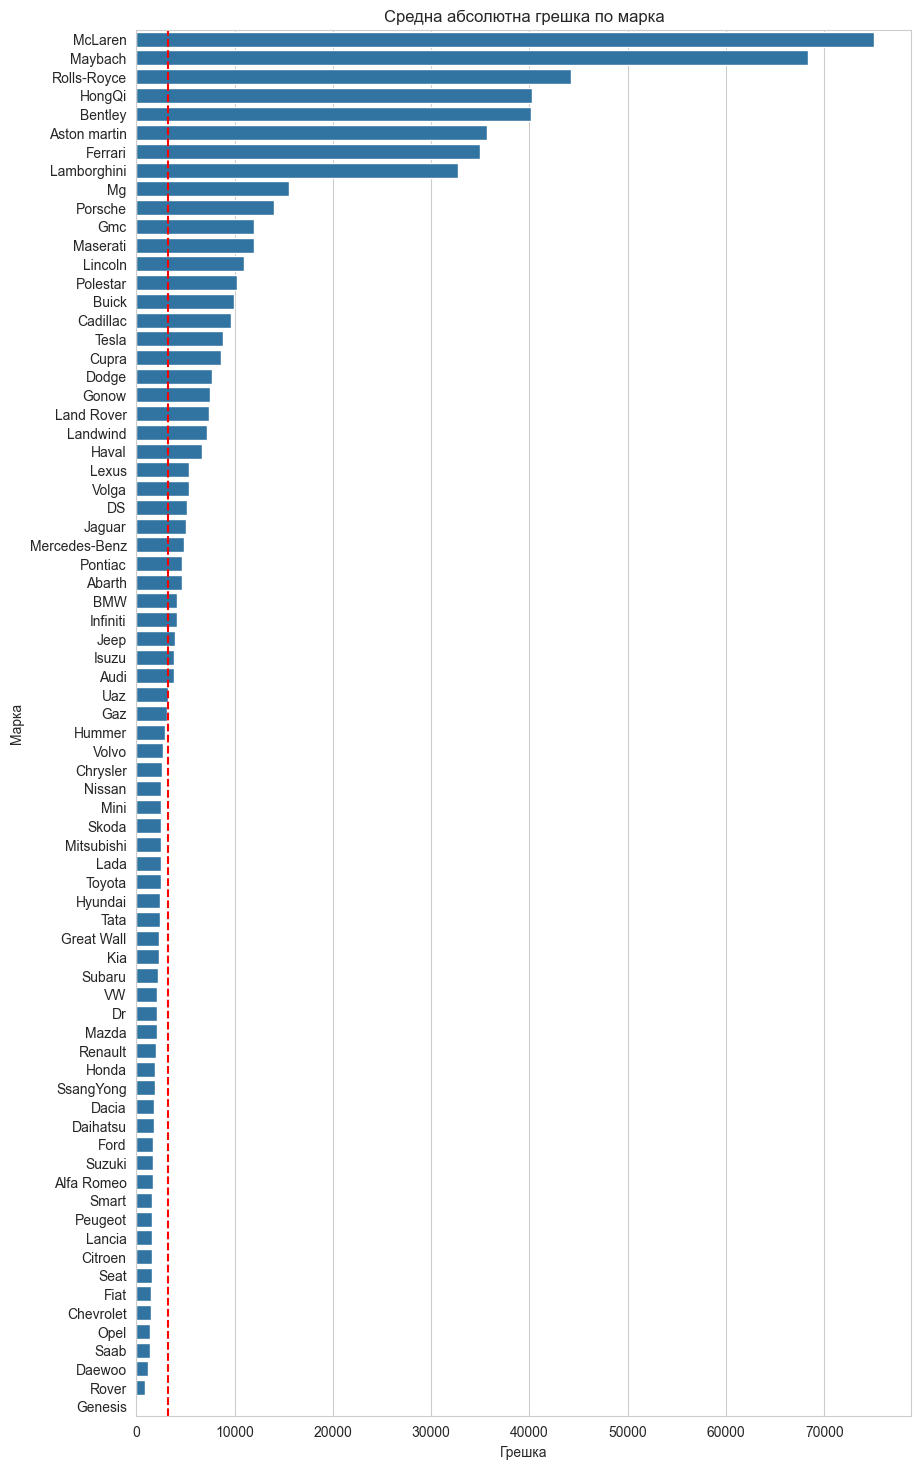

In [146]:
import seaborn as sns

# Group by 'Make' and calculate the mean error
mean_error_by_make = errors_df.groupby('Make')['Error'].mean().reset_index()

plt.figure(figsize=(10, 18))
ax = sns.barplot(x='Error', y='Make', data=mean_error_by_make.sort_values(by='Error', ascending=False), orient='h')
ax.axvline(errors_df['Error'].mean(), color='red', linestyle='--')
plt.title('Средна абсолютна грешка по марка')
plt.ylabel('Марка')
plt.xlabel('Грешка')
plt.show()

In [147]:
errors_df['Error value % of target'] = errors_df['Error'] / errors_df['Price'] * 100

print(f'Mean error value % of target {errors_df['Error value % of target'].mean()}')

errors_df.groupby('Make')['Error value % of target'].mean().sort_values(ascending=False)

Mean error value % of target 18.502218287841064


Make
Mg              203.70
Volga           133.86
Landwind         96.19
Pontiac          88.19
Gonow            88.05
Rolls-Royce      84.33
Maybach          45.60
Gaz              41.67
Lada             41.44
Bentley          41.33
Tata             37.45
Rover            36.89
Buick            36.73
Daihatsu         35.66
Daewoo           35.59
Saab             34.74
Dr               31.89
Lancia           30.06
McLaren          30.04
Chrysler         29.90
Isuzu            28.41
HongQi           27.79
Gmc              26.20
Alfa Romeo       25.03
Uaz              24.72
Mitsubishi       24.28
Land Rover       22.52
Great Wall       22.16
Fiat             22.07
SsangYong        21.68
Subaru           21.23
Kia              21.12
Citroen          20.65
Cadillac         19.85
Seat             19.47
VW               19.34
BMW              19.01
Lincoln          19.01
Opel             18.99
Mercedes-Benz    18.93
Chevrolet        18.80
Jeep             18.57
Renault          18.43
Ford  

Text(0.5, 0, 'Грешка в % от цената')

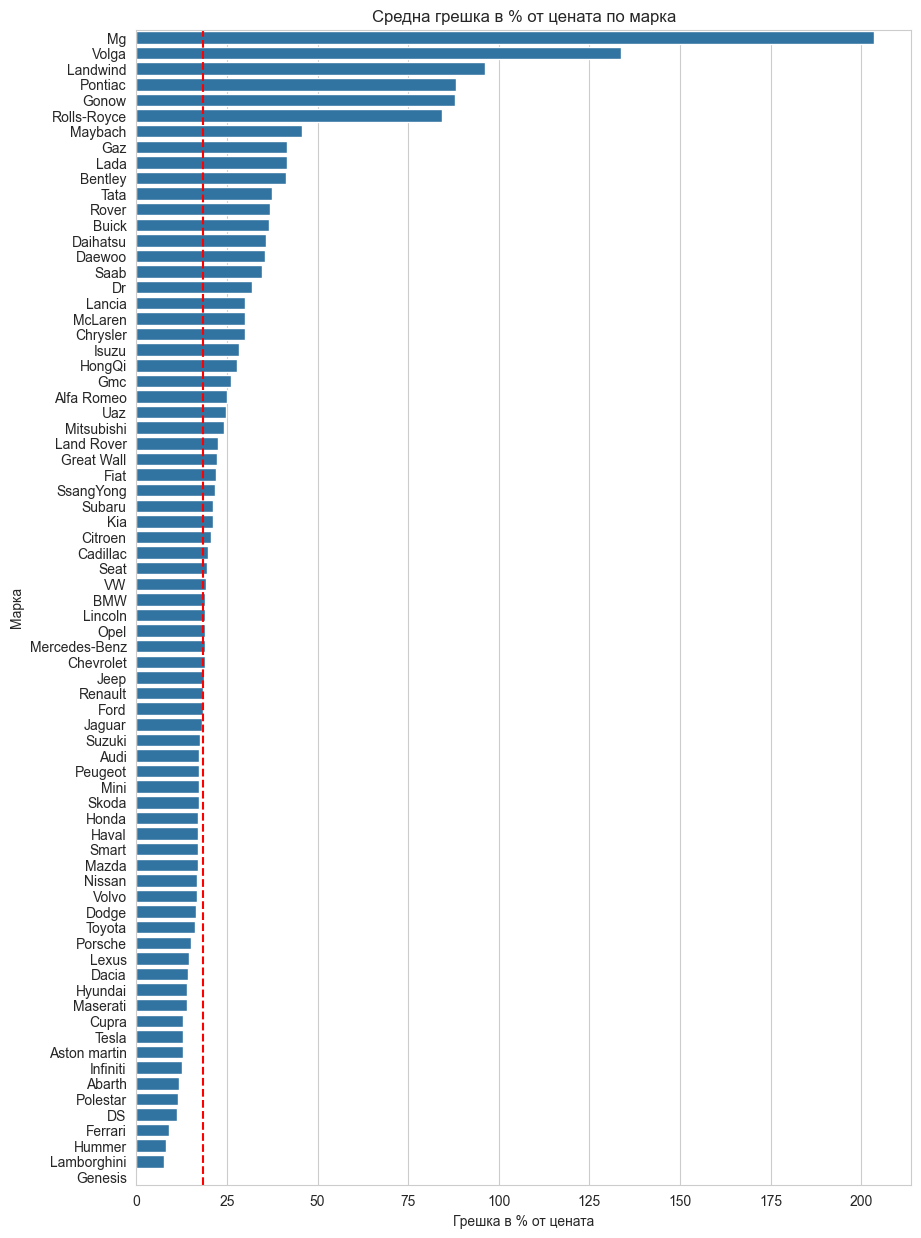

In [148]:
plt.figure(figsize=(10, 15))

ax = sns.barplot(x='Error value % of target', y='Make', data=errors_df.groupby('Make')['Error value % of target'].mean().reset_index().sort_values(by='Error value % of target', ascending=False), orient='h')
ax.axvline(errors_df['Error value % of target'].mean(), color='red', linestyle='--')
plt.title('Средна грешка в % от цената по марка')
plt.ylabel('Марка')
plt.xlabel('Грешка в % от цената')

# Експортиране на модела

In [92]:
learner.export(fname='../models/nn-car-price-model.pkl')